Reference video: https://www.youtube.com/watch?v=0UISM-V5Lbw

In [ ]:
# Import necessary libraries
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

Define some parameters

In [8]:
gamma = 0.99
learning_rate = 0.001
hidden_dim = 128
max_episodes = 2500
max_steps = 1000
env_name = 'CartPole-v1'

Define the Actor Critic policy architecture

In [3]:
class ActorCritic(nn.Module):
    
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(ActorCritic, self).__init__()
        
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.actor = nn.Linear(hidden_dim, action_dim)
        self.critic = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action_probs = F.softmax(self.actor(x), dim=1)
        state_value = self.critic(x)
        return action_probs, state_value

Initialize the environment

In [4]:
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

Initialize the model

In [5]:
model =  ActorCritic(state_dim, action_dim, hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Train the agent

In [9]:
episode_rewards = []

for episode in range(1, max_episodes + 1):
    state, _ = env.reset()
    state = T.FloatTensor(state).unsqueeze(0)  # shape [1, obs_dim]
    ep_reward = 0.0

    log_probs = []
    values = []
    rewards = []

    for step in range(max_steps):
        action_output, value = model(state)  # action_output: logits OR probs, value: tensor scalar or [1,]
        
        # If model gives logits, use Categorical(logits=action_output)
        # If model gives probabilities, use Categorical(probs=action_output)
        # Here we assume logits (preferred):
        dist = Categorical(logits=action_output)
        action = dist.sample()
        log_prob = dist.log_prob(action)  # tensor shape [1]
        
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        next_state = T.FloatTensor(next_state).unsqueeze(0)

        ep_reward += reward

        log_probs.append(log_prob)            # list of tensors [1]
        values.append(value.squeeze())        # store tensor scalar (no extra dims)
        rewards.append(reward)

        state = next_state

        if done:
            break

    # compute returns (list -> tensor)
    returns = []
    R = 0.0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)

    returns = T.FloatTensor(returns)                 # shape [T]
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    # stack log_probs and values into tensors for easier ops
    log_probs = T.stack(log_probs).squeeze()        # shape [T]
    values = T.stack(values).squeeze()              # shape [T]

    # compute advantages as tensors
    advantages = returns - values
    # actor loss uses advantage.detach() so critic doesn't get gradients from actor term
    actor_loss = - (log_probs * advantages.detach()).mean()
    # critic loss (MSE)
    critic_loss = advantages.pow(2).mean()
    total_loss = actor_loss + critic_loss * 0.5

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    episode_rewards.append(ep_reward)
    avg_reward = np.mean(episode_rewards[-100:])
    
    if episode % 100 == 0:
        print(f"Episode {episode} avg reward: {avg_reward:.2f}")
    
    if episode >=100 and avg_reward >= 195:
        print(f"Episode {episode} best avg reward: {avg_reward:.2f}")
        break

T.save(model.state_dict(), "cartpole_a2c.pth")
print("Model saved!")

Episode 100 avg reward: 133.37
Episode 200 avg reward: 140.32
Episode 300 avg reward: 123.39
Episode 400 avg reward: 129.87
Episode 500 avg reward: 119.51
Episode 600 avg reward: 132.60
Episode 700 avg reward: 128.31
Episode 800 avg reward: 129.85
Episode 900 avg reward: 134.51
Episode 1000 avg reward: 135.95
Episode 1100 avg reward: 123.81
Episode 1200 avg reward: 145.65
Episode 1300 avg reward: 124.01
Episode 1400 avg reward: 145.42
Episode 1500 avg reward: 143.66
Episode 1600 avg reward: 150.69
Episode 1700 avg reward: 128.36
Episode 1800 avg reward: 136.66
Episode 1900 avg reward: 153.48
Episode 2000 avg reward: 126.69
Episode 2100 avg reward: 143.69
Episode 2200 avg reward: 134.25
Episode 2300 avg reward: 137.47
Episode 2400 avg reward: 139.80
Episode 2500 avg reward: 153.23
Model saved!


Plot the reward per episode graph

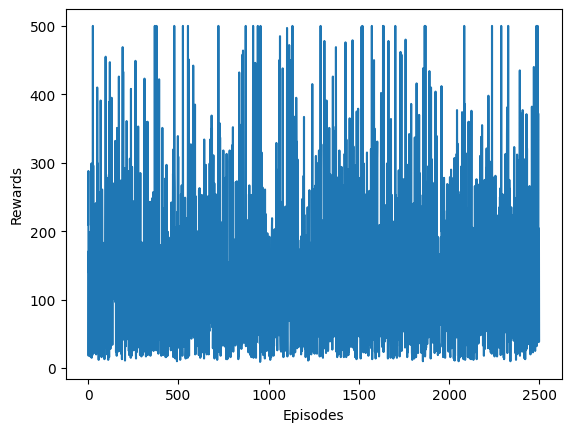

In [10]:
plt.plot(episode_rewards)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

Load the saved model

In [12]:
model = ActorCritic(state_dim, action_dim, hidden_dim)
model.load_state_dict(
    T.load("cartpole_a2c.pth", map_location="cpu")
)
model.eval()

ActorCritic(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (actor): Linear(in_features=128, out_features=2, bias=True)
  (critic): Linear(in_features=128, out_features=1, bias=True)
)

Test the model

In [14]:
env = gym.make(env_name, render_mode='human')

for ep in range(3):
    state, _ = env.reset()
    state = T.FloatTensor(state).unsqueeze(0)
    total_reward = 0
    done = False
    
    while not done:
        with T.no_grad():
            action_probs, _ = model(state)
            action = T.argmax(action_probs, dim=1).item()
        
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        state = T.FloatTensor(next_state).unsqueeze(0)
    
    print(f"Episode {ep + 1} total rewards: {total_reward}")

env.close()

Episode 1 total rewards: 500.0
Episode 2 total rewards: 500.0
Episode 3 total rewards: 500.0
